In [2]:
import os
import sys
import time
import math
import argparse

import numpy as np
from scipy import stats
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt

from gmm_tree import gmm_clustering

In [3]:
# Nov. 2013 dump of Wikipedia, only articles with at least 20 pageviews, leaving 460k documents. 
train_file = '/home/matthias/data/wikipedia.txt'
# Checkout and build https://github.com/mleimeister/fastText/tree/hs_precomputed_tree
fasttext = '/home/matthias/fastText/fasttext'
# Directory to store the trained vectors
save_path = '/home/matthias/tmp/'
# Questions file for the word analogy task
questions_file = '/home/matthias/data/questions-words.txt'
# File for word similarity task
dataPath = '/home/matthias/data/rw.txt'

In [4]:
# Set the dimensions of the embedding vectors, for each there will be a separate training and evaluation run
dims = [50, 100, 400]

In [5]:
def print_formated_time(elapsed, outfile=None):
    hours, rem = divmod(elapsed, 3600)
    minutes, seconds = divmod(rem, 60)
    s = 'Elapsed time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours),int(minutes),seconds)
    print(s)
    if outfile is not None:
        with open(outfile, 'a') as f:
            f.write('Elapsed time: {}\n'.format(s))

In [5]:
# Run cbow fastText using hierarchical softmax with Huffman tree
for dim in dims:
    out_vec_file = save_path + 'vecs_huffman_' + str(dim)
    results_file = save_path + 'results_huffman_' + str(dim) + '.txt'

    exec_str = fasttext + ' cbow -input ' + train_file + ' -output ' + out_vec_file + \
              ' -minCount 25 -minn 0 -maxn 0 -t 0.00001 -lr 0.05 -dim ' + str(dim) + ' -ws 10 ' + \
              '-epoch 3 -loss hs -thread 48'

    print('Running fastText in dimension {}'.format(dim))
    start = time.time()
    os.system(exec_str)
    elapsed = time.time() - start
    with open(results_file, 'w') as f:
        f.write(exec_str + '\n')
    print_formated_time(elapsed, results_file)

Running fastText in dimension 50
Elapsed time: 00:05:15.40
Running fastText in dimension 100
Elapsed time: 00:05:32.80
Running fastText in dimension 400
Elapsed time: 00:11:07.24


In [6]:
# Generate tree index for semantic tree based on Huffman word vectors
for dim in dims:
    out_vec_file = save_path + 'vecs_huffman_' + str(dim)
    start = time.time()
    tree_index = save_path + 'tree_index_' + str(dim) + '.txt'
    gmm_clustering(out_vec_file + '.vec', tree_index)
    elapsed = time.time() - start
    print_formated_time(elapsed, None)

/usr/local/lib/python3.5/dist-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Final number of leaves: 213480
Size of vocabulary: 213480
Number of internal nodes: 213479
Mean code word length: 21.53803166572981
Elapsed time: 00:09:35.69
Final number of leaves: 213480
Size of vocabulary: 213480
Number of internal nodes: 213479
Mean code word length: 21.91010867528574
Elapsed time: 00:10:30.30
Final number of leaves: 213480
Size of vocabulary: 213480
Number of internal nodes: 213479
Mean code word length: 21.31884017238149
Elapsed time: 00:13:52.90


In [6]:
# Run cbow fastText using hierarchical softmax with the semantic tree
for dim in dims:
    tree_index = save_path + 'tree_index_' + str(dim) + '.txt'
    out_vec_file = save_path + 'vecs_gmm_' + str(dim)
    results_file = save_path + 'results_gmm_' + str(dim) + '.txt'

    exec_str = fasttext + ' cbow -input ' + train_file + ' -output ' + out_vec_file + \
              ' -minCount 25 -minn 0 -maxn 0 -t 0.00001 -lr 0.05 -dim ' + str(dim) + ' -ws 10 ' + \
              '-epoch 3 -loss hs -thread 48 -tree ' + tree_index

    print('Running fastText in dimension {}'.format(dim))
    start = time.time()
    os.system(exec_str)
    elapsed = time.time() - start
    with open(results_file, 'w') as f:
        f.write(exec_str + '\n')
    print_formated_time(elapsed, results_file)

Running fastText in dimension 50
Elapsed time: 00:03:52.83
Running fastText in dimension 100
Elapsed time: 00:04:42.08
Running fastText in dimension 400
Elapsed time: 00:10:43.10


In [7]:
# Evaluation using the word analogy task.
def print_accuracy(acc):
    sem_correct = sum((len(acc[i]['correct']) for i in range(5)))
    sem_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5))
    sem_acc = 100*float(sem_correct)/sem_total
    print('Semantic: {:d}/{:d}, Accuracy: {:.2f}%'.format(sem_correct, sem_total, sem_acc))
    
    syn_correct = sum((len(acc[i]['correct']) for i in range(5, len(acc)-1)))
    syn_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5,len(acc)-1))
    syn_acc = 100*float(syn_correct)/syn_total
    print('Syntactic: {:d}/{:d}, Accuracy: {:.2f}%'.format(syn_correct, syn_total, syn_acc))
    
    total_correct = sem_correct + syn_correct
    total = sem_total + syn_total
    total_acc = 100*float(total_correct)/total
    print('Total: {:d}/{:d}, Accuracy: {:.2f}%\n'.format(total_correct, total, total_acc))
    return (sem_acc, syn_acc, total_acc)

def evaluate_accuracy(vecs_file):
    model = KeyedVectors.load_word2vec_format(vecs_file)
    acc = model.accuracy(questions_file)
    _, _, total_acc = print_accuracy(acc)
    return total_acc

In [8]:
print('Evaluating word analogy task...')

acc_huffman = []
acc_gmm = []

for dim in dims:
    print('Dimension: {}'.format(dim))
    print('Huffman tree:')
    acc = evaluate_accuracy(save_path + 'vecs_huffman_' + str(dim) + '.vec')
    acc_huffman.append(acc)
    with open(save_path + 'results_huffman_' + str(dim) + '.txt', 'a') as f:
        f.write('Analogy score: {}\n'.format(acc))
    print('GMM tree:')
    acc = evaluate_accuracy(save_path + 'vecs_gmm_' + str(dim) + '.vec')
    acc_gmm.append(acc)
    with open(save_path + 'results_gmm_' + str(dim) + '.txt', 'a') as f:
        f.write('Analogy score: {}\n'.format(acc))

Evaluating word analogy task...
Dimension: 50
Huffman tree:
Semantic: 2345/4976, Accuracy: 47.13%
Syntactic: 3566/8429, Accuracy: 42.31%
Total: 5911/13405, Accuracy: 44.10%

GMM tree:
Semantic: 2897/4976, Accuracy: 58.22%
Syntactic: 4084/8429, Accuracy: 48.45%
Total: 6981/13405, Accuracy: 52.08%

Dimension: 100
Huffman tree:
Semantic: 3270/4976, Accuracy: 65.72%
Syntactic: 4466/8429, Accuracy: 52.98%
Total: 7736/13405, Accuracy: 57.71%

GMM tree:
Semantic: 3464/4976, Accuracy: 69.61%
Syntactic: 5031/8429, Accuracy: 59.69%
Total: 8495/13405, Accuracy: 63.37%

Dimension: 400
Huffman tree:
Semantic: 3798/4976, Accuracy: 76.33%
Syntactic: 4900/8429, Accuracy: 58.13%
Total: 8698/13405, Accuracy: 64.89%

GMM tree:
Semantic: 3848/4976, Accuracy: 77.33%
Syntactic: 5378/8429, Accuracy: 63.80%
Total: 9226/13405, Accuracy: 68.83%



In [9]:
# Evaluation functions for the Stanfor rare words dataset. 
# Copied from https://github.com/facebookresearch/fastText/blob/master/eval.py
def compat_splitting(line):
    return line.decode('utf8').split()

def similarity(v1, v2):
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    return np.dot(v1, v2) / n1 / n2

def compute_sim_correlation(vecs_file):
    vectors = {}
    fin = open(vecs_file, 'rb')
    for i, line in enumerate(fin):
        try:
            tab = compat_splitting(line)
            vec = np.array(tab[1:], dtype=float)
            word = tab[0]
            if not word in vectors:
                vectors[word] = vec
        except ValueError:
            continue
        except UnicodeDecodeError:
            continue
    fin.close()

    mysim = []
    gold = []
    drop = 0.0
    nwords = 0.0

    fin = open(dataPath, 'rb')
    for line in fin:
        tline = compat_splitting(line)
        word1 = tline[0].lower()
        word2 = tline[1].lower()
        nwords = nwords + 1.0

        if (word1 in vectors) and (word2 in vectors):
            v1 = vectors[word1]
            v2 = vectors[word2]
            d = similarity(v1, v2)
            mysim.append(d)
            gold.append(float(tline[2]))
        else:
            drop = drop + 1.0
    fin.close()

    corr = stats.spearmanr(mysim, gold)
    dataset = os.path.basename(dataPath)
    print("{0:20s}: {1:2.0f}  (OOV: {2:2.0f}%)"
    .format(dataset, corr[0] * 100, math.ceil(drop / nwords * 100.0)))
    
    return corr[0]

In [10]:
print('Evaluating word similarity task...')

corr_huffman = []
corr_gmm = []

for dim in dims:
    print('Dimension: {}'.format(dim))
    print('Huffman tree:')
    c = compute_sim_correlation(save_path + 'vecs_huffman_' + str(dim) + '.vec')
    corr_huffman.append(c)
    with open(save_path + 'results_huffman_' + str(dim) + '.txt', 'a') as f:
        f.write('Similarity correlation: {}\n'.format(acc))
    print('GMM tree:')
    c = compute_sim_correlation(save_path + 'vecs_gmm_' + str(dim) + '.vec')
    corr_gmm.append(c)
    with open(save_path + 'results_gmm_' + str(dim) + '.txt', 'a') as f:
        f.write('Similarity correlation: {}\n'.format(acc))

Evaluating word similarity task...
Dimension: 50
Huffman tree:
rw.txt              : 40  (OOV: 24%)
GMM tree:
rw.txt              : 42  (OOV: 24%)
Dimension: 100
Huffman tree:
rw.txt              : 44  (OOV: 24%)
GMM tree:
rw.txt              : 44  (OOV: 24%)
Dimension: 400
Huffman tree:
rw.txt              : 43  (OOV: 24%)
GMM tree:
rw.txt              : 44  (OOV: 24%)


In [11]:
def plot_results(huffman_score, gmm_score, figure_title, ylabel, ylimits):

    pos = range(3)
    width = 0.25

    fig, ax = plt.subplots(figsize=(10,5))

    plt.bar([p - 0.5*width for p in pos],
            huffman_score,
            width,
            alpha=0.5,
            color='r')

    plt.bar([p + 0.5*width for p in pos],
            gmm_score,
            width,
            alpha=0.5,
            color='b')

    ax.set_ylabel(ylabel)
    ax.set_xlabel('Embedding dimension')
    ax.set_title(figure_title)
    ax.set_xticks(pos)
    ax.set_xticklabels([50, 100, 400])
    plt.xlim(min(pos)-2*width, max(pos)+width*2)
    plt.ylim(ylimits)

    plt.legend(['Huffman tree', 'GMM tree'], loc='upper left')
    plt.grid()
    plt.show()

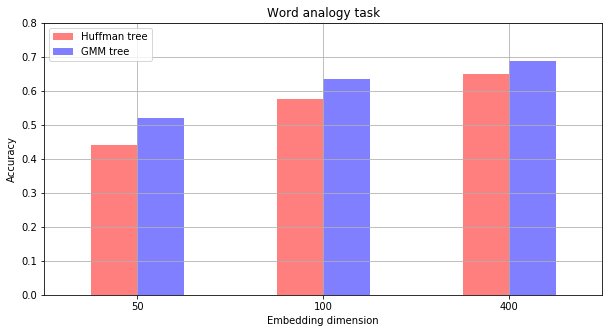

In [12]:
plot_results([a/100 for a in acc_huffman], [a/100 for a in acc_gmm], 'Word analogy task', 'Accuracy', [0, 0.8])

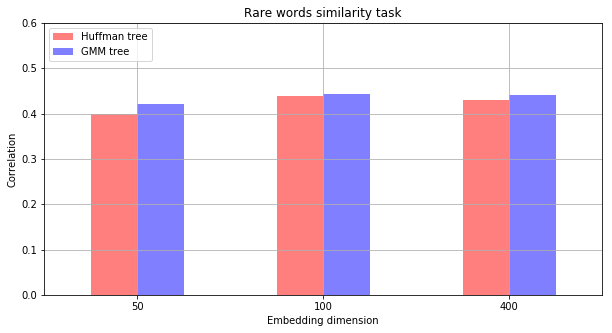

In [13]:
plot_results(corr_huffman, corr_gmm, 'Rare words similarity task', 'Correlation', [0, 0.6])